# 🔥 Modèle de Préchauffage

Ce notebook centralise tout le pipeline ML pour le modèle de préchauffage :
1. **Extraction des données** depuis les fichiers CSV du simulateur
2. **Exploration et visualisation** des données
3. **Feature Engineering** avancé
4. **Entraînement et optimisation** du modèle (XGBoost)
5. **Évaluation et export** du modèle final

**Objectif** : R² ≥ 0.80

---
## 1. Configuration et Imports

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime
from typing import List, Tuple
import warnings

# ML
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler



print("✅ Imports chargés avec succès")

✅ Imports chargés avec succès


In [64]:
# === Configuration du pipeline ===
CONFIG = {
    'data_dir': './data',           # Répertoire des données CSV
    'output_csv': 'training_data.csv',  # Fichier de sessions extraites
    'model_output': 'heating_model.json',  # Modèle final
    'test_size': 0.2,               # Proportion test set
    'random_state': 42,             # Seed pour reproductibilité
    'target_r2': 0.80,              # Objectif R²
    'session_min_duration': 1,      # Durée min session (minutes)
    'session_max_duration': 120,    # Durée max session (minutes)
    'min_delta_temp': 0.3,          # Delta temp minimum pour session valide
}

print("📋 Configuration:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")

📋 Configuration:
   data_dir: ./data
   output_csv: training_data.csv
   model_output: heating_model.json
   test_size: 0.2
   random_state: 42
   target_r2: 0.8
   session_min_duration: 1
   session_max_duration: 120
   min_delta_temp: 0.3


---
## 2. Extraction des Données

Chargement des fichiers CSV générés par le simulateur et extraction des sessions de chauffage.

In [ ]:
def find_csv_files(data_dir: str) -> List[str]:
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"[WARN] Repertoire non trouve: {data_dir}")
        print("   Exécutez d'abord:")
        print("   cd ../data-generator && python generate.py --mode batch --days 180 --output ../IA/data") # Nov 2024 à Jan 2025
        return []
    
    csv_files = list(data_path.glob("*.csv"))
    return [str(f) for f in csv_files]


def load_all_csvs(csv_files: List[str]) -> pd.DataFrame:
    """Charge tous les fichiers CSV en un seul DataFrame."""
    if not csv_files:
        return pd.DataFrame()
    
    dfs = []
    for f in csv_files:
        try:
            df = pd.read_csv(f)
            # Extraire apartment_id du nom de fichier (ex: apt_101_2025-12-01.csv)
            filename = os.path.basename(f)
            parts = filename.replace(".csv", "").split("_")
            if len(parts) >= 2:
                apt_id = f"{parts[0]}_{parts[1]}".upper()
                df["apartment_id"] = apt_id
            dfs.append(df)
        except Exception as e:
            print(f"Erreur lecture {f}: {e}")
    
    if not dfs:
        return pd.DataFrame()
    
    return pd.concat(dfs, ignore_index=True)



csv_files = find_csv_files(CONFIG['data_dir'])
print(f"📁 Fichiers CSV trouvés: {len(csv_files)}")

raw_data = load_all_csvs(csv_files)
print(f"📊 Enregistrements chargés: {len(raw_data):,}")

📁 Fichiers CSV trouvés: 810
📊 Enregistrements chargés: 414,720


In [66]:
# Aperçu des données brutes
if not raw_data.empty:
    print("=== Aperçu des données brutes ===")
    display(raw_data.head(10))
    
    print(f"\n=== Types ===")
    print(raw_data.dtypes)

=== Aperçu des données brutes ===


,timestamp,apartment_id,room,window_open,heater_on,presence,temperature,humidity,co2,pm25,co,tvoc,temp_ext,humidity_ext,energy_kwh,temp_preference
0,2024-11-01T00:00:00,APT_101,chambre_1,False,True,True,21.5,49.8,NaN,15.41,0.79,254.34,14.0,63.0,0.2000,24.0
1,2024-11-01T00:00:00,APT_101,chambre_2,False,True,True,21.5,50.9,NaN,15.59,0.79,253.41,14.0,63.0,0.1667,24.0
2,2024-11-01T00:00:00,APT_101,cuisine,False,True,True,21.7,49.1,558.0,16.05,0.79,253.54,14.0,63.0,0.1333,24.0
3,2024-11-01T00:00:00,APT_101,salon,False,True,True,21.6,49.4,557.0,15.38,0.80,260.77,14.0,63.0,0.3000,24.0
4,2024-11-01T00:00:00,APT_101,sdb,False,True,True,21.5,49.4,NaN,15.11,0.79,260.39,14.0,63.0,0.0667,24.0
5,2024-11-01T00:10:00,APT_101,chambre_1,False,True,True,21.5,49.3,NaN,16.56,0.77,255.09,14.0,63.5,0.4000,24.0
6,2024-11-01T00:10:00,APT_101,chambre_2,False,True,True,21.6,51.2,NaN,16.72,0.77,261.84,14.0,63.5,0.3334,24.0
7,2024-11-01T00:10:00,APT_101,cuisine,False,True,True,21.6,49.6,565.0,17.64,0.78,264.10,14.0,63.5,0.2666,24.0
8,2024-11-01T00:10:00,APT_101,salon,False,True,True,21.7,50.3,562.0,16.14,0.80,265.13,14.0,63.5,0.6000,24.0
9,2024-11-01T00:10:00,APT_101,sdb,False,True,True,21.6,50.4,NaN,16.00,0.79,265.58,14.0,63.5,0.1334,24.0



=== Types ===
timestamp           object
apartment_id        object
room                object
window_open         object
heater_on           object
presence            object
temperature        float64
humidity           float64
co2                float64
pm25               float64
co                 float64
tvoc               float64
temp_ext           float64
humidity_ext       float64
energy_kwh         float64
temp_preference    float64
dtype: object


In [67]:
def extract_heating_sessions(df: pd.DataFrame, config: dict) -> pd.DataFrame:
    """
    Extrait les sessions de chauffage du DataFrame.
    
    Une session = période où heater_on passe de False à True jusqu'à temp >= temp_preference.
    """
    sessions = []
    
    df = df.sort_values(["apartment_id", "room", "timestamp"]).reset_index(drop=True)
    
    for (apt_id, room), group in df.groupby(["apartment_id", "room"]):
        session_start_idx = None
        
        for idx, row in group.iterrows():
            heater_on = row.get("heater_on", False)
            temp = row.get("temperature", 0)
            temp_pref = row.get("temp_preference", 21)
            
            # Début d'une session
            if heater_on and session_start_idx is None:
                session_start_idx = idx
            
            # Fin de session
            elif session_start_idx is not None:
                if not heater_on or temp >= temp_pref:
                    start_row = group.loc[session_start_idx]
                    
                    start_time = pd.to_datetime(start_row.get("timestamp"))
                    end_time = pd.to_datetime(row.get("timestamp"))
                    
                    if pd.notna(start_time) and pd.notna(end_time):
                        duration_min = (end_time - start_time).total_seconds() / 60
                        delta = temp - start_row.get("temperature", 0)
                        
                        # Filtrer sessions réalistes
                        if (config['session_min_duration'] < duration_min < config['session_max_duration'] 
                            and delta >= config['min_delta_temp']):
                            sessions.append({
                                "apartment_id": apt_id,
                                "room": room,
                                "temp_start": start_row.get("temperature"),
                                "temp_end": temp,
                                "temp_preference": start_row.get("temp_preference", 21),
                                "temp_ext": start_row.get("temp_ext", 10),
                                "humidity_ext": start_row.get("humidity_ext", 50),
                                "delta_temp": delta,
                                "hour": start_time.hour,
                                "day_of_week": start_time.dayofweek,
                                "is_weekend": 1 if start_time.dayofweek >= 5 else 0,
                                "timestamp": str(start_time),
                                "duration_min": round(duration_min, 1)
                            })
                    
                    session_start_idx = None
    
    return pd.DataFrame(sessions)


# Extraire les sessions
print("🔄 Extraction des sessions de chauffage...")
sessions_df = extract_heating_sessions(raw_data, CONFIG)
print(f"✅ {len(sessions_df)} sessions extraites")

🔄 Extraction des sessions de chauffage...
✅ 3608 sessions extraites


In [69]:
# Sauvegarder les sessions extraites
if not sessions_df.empty:
    sessions_df.to_csv(CONFIG['output_csv'], index=False)
    print(f"💾 Sessions sauvegardées: {CONFIG['output_csv']}")
    
    # Statistiques
    print(f"\n=== Statistiques des sessions ===")
    print(f"   Appartements: {sessions_df['apartment_id'].nunique()}")
    print(f"   Pièces: {sessions_df['room'].nunique()}")
    print(f"   Durée moyenne: {sessions_df['duration_min'].mean():.1f} min")
    print(f"   Durée médiane: {sessions_df['duration_min'].median():.1f} min")
    print(f"   Delta temp moyen: {sessions_df['delta_temp'].mean():.2f}°C")
    
    display(sessions_df.head(10))

💾 Sessions sauvegardées: training_data.csv

=== Statistiques des sessions ===
   Appartements: 8
   Pièces: 7
   Durée moyenne: 43.2 min
   Durée médiane: 40.0 min
   Delta temp moyen: 0.71°C


,apartment_id,room,temp_start,temp_end,temp_preference,temp_ext,humidity_ext,delta_temp,hour,day_of_week,is_weekend,timestamp,duration_min
0,APT_101,chambre_1,22.0,22.4,24.0,18.3,54.5,0.4,12,5,1,2024-11-09 12:10:00,50.0
1,APT_101,chambre_1,19.6,21.0,24.0,14.8,72.2,1.4,10,5,1,2024-11-16 10:10:00,60.0
2,APT_101,chambre_1,21.3,21.6,24.0,15.3,71.0,0.3,12,5,1,2024-11-16 12:30:00,70.0
3,APT_101,chambre_1,21.3,21.7,24.0,15.3,67.3,0.4,11,6,1,2024-11-17 11:20:00,90.0
4,APT_101,chambre_1,19.0,19.4,24.0,12.6,45.8,0.4,10,5,1,2024-11-23 10:50:00,30.0
5,APT_101,chambre_1,19.9,20.2,24.0,12.9,46.0,0.3,11,5,1,2024-11-23 11:50:00,30.0
6,APT_101,chambre_1,20.6,21.1,24.0,12.8,46.0,0.5,13,5,1,2024-11-23 13:00:00,70.0
7,APT_101,chambre_1,20.9,21.2,24.0,12.2,52.3,0.3,14,5,1,2024-11-23 14:40:00,100.0
8,APT_101,chambre_1,19.8,20.1,24.0,13.0,88.0,0.3,10,6,1,2024-11-24 10:10:00,30.0
9,APT_101,chambre_1,20.0,20.5,24.0,12.5,59.7,0.5,10,5,1,2024-12-07 10:10:00,40.0


---
## 3. Exploration et Visualisation

Analyse exploratoire pour comprendre les patterns dans les données.

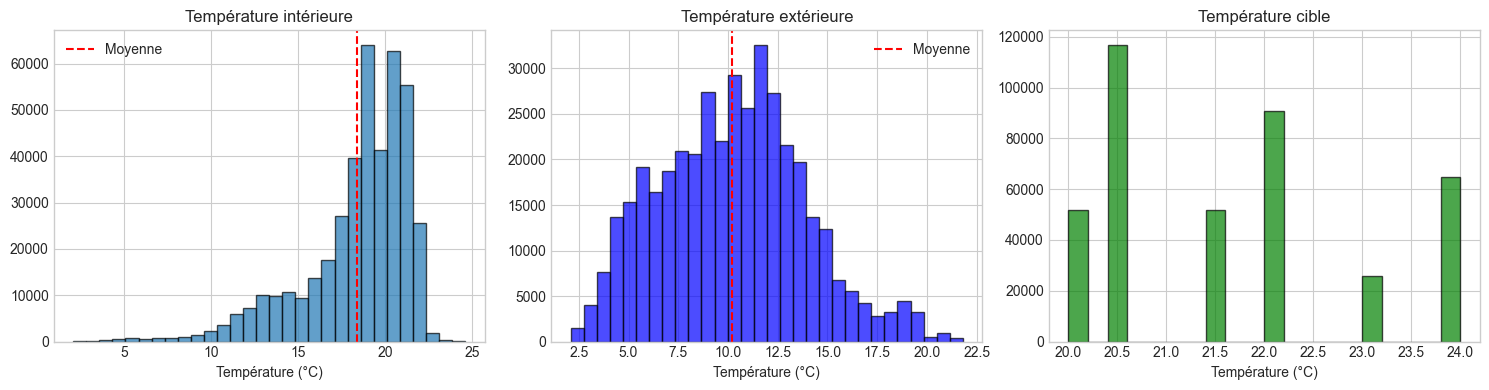

=== Statistiques des températures ===
Temp intérieure: min=2.1, max=24.6, mean=18.4
Temp extérieure: min=2.1, max=21.8, mean=10.2


In [ ]:
# Distribution des températures 
if not raw_data.empty:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(raw_data['temperature'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(raw_data['temperature'].mean(), color='red', linestyle='--', label='Moyenne')
    axes[0].set_title('Température intérieure')
    axes[0].set_xlabel('Température (°C)')
    axes[0].legend()
    
    axes[1].hist(raw_data['temp_ext'], bins=30, edgecolor='black', color='blue', alpha=0.7)
    axes[1].axvline(raw_data['temp_ext'].mean(), color='red', linestyle='--', label='Moyenne')
    axes[1].set_title('Température extérieure')
    axes[1].set_xlabel('Température (°C)')
    axes[1].legend()
    
    axes[2].hist(raw_data['temp_preference'], bins=20, edgecolor='black', color='green', alpha=0.7)
    axes[2].set_title('Température cible')
    axes[2].set_xlabel('Température (°C)')
    
    plt.tight_layout()
    plt.show()
    
    print("=== Statistiques des températures ===")
    print(f"Temp intérieure: min={raw_data['temperature'].min():.1f}, max={raw_data['temperature'].max():.1f}, mean={raw_data['temperature'].mean():.1f}")
    print(f"Temp extérieure: min={raw_data['temp_ext'].min():.1f}, max={raw_data['temp_ext'].max():.1f}, mean={raw_data['temp_ext'].mean():.1f}")

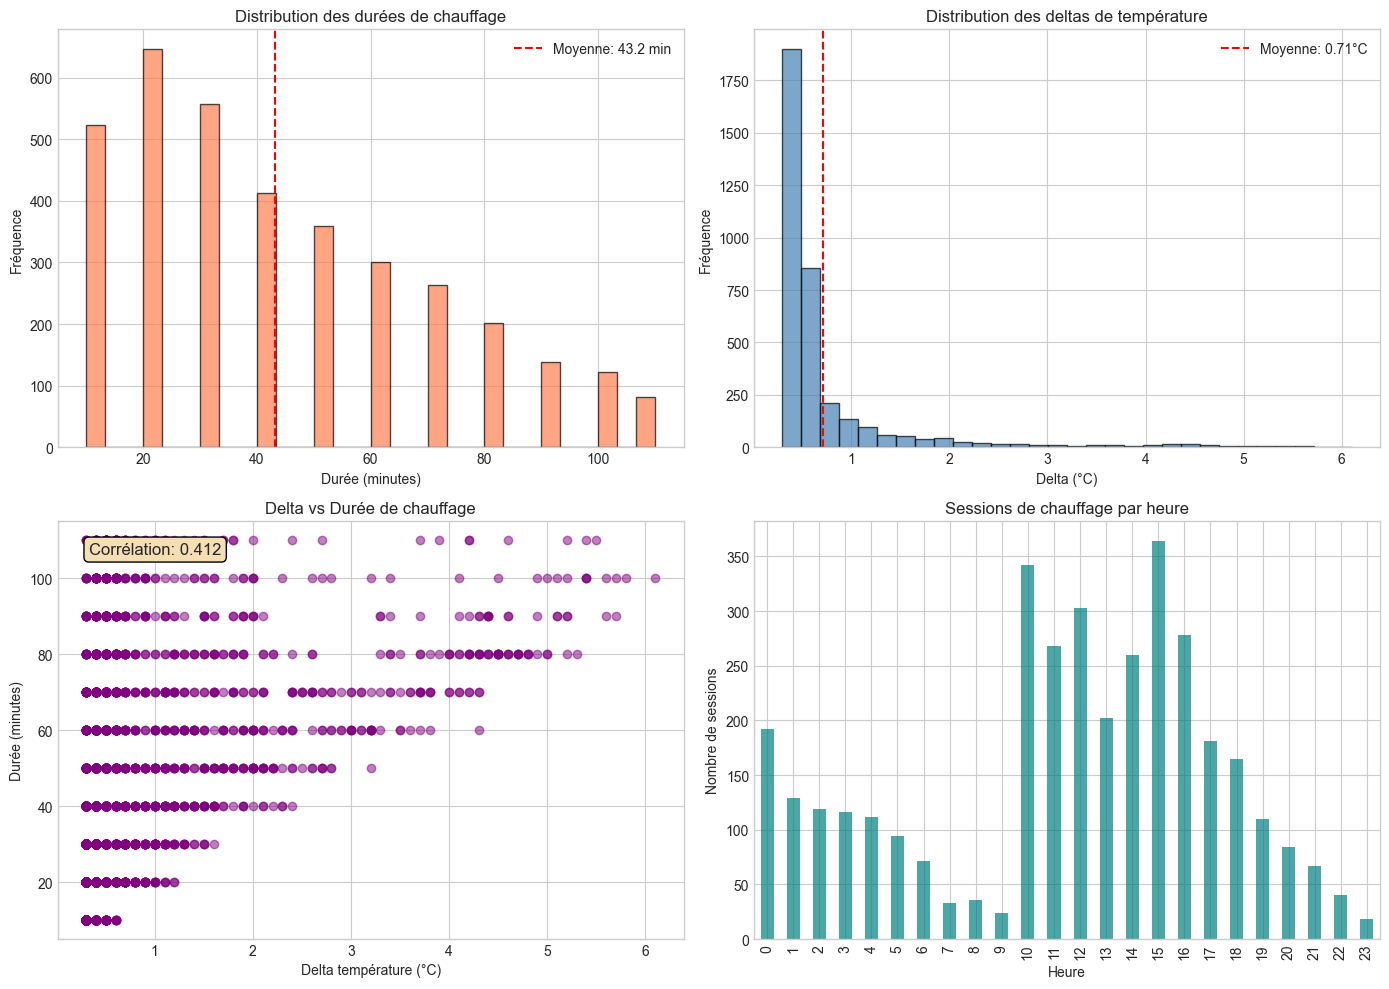

In [73]:
# Distribution des sessions de chauffage
if not sessions_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Durée de chauffage
    axes[0, 0].hist(sessions_df['duration_min'], bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[0, 0].axvline(sessions_df['duration_min'].mean(), color='red', linestyle='--', 
                       label=f"Moyenne: {sessions_df['duration_min'].mean():.1f} min")
    axes[0, 0].set_title('Distribution des durées de chauffage')
    axes[0, 0].set_xlabel('Durée (minutes)')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].legend()
    
    # Delta température
    axes[0, 1].hist(sessions_df['delta_temp'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].axvline(sessions_df['delta_temp'].mean(), color='red', linestyle='--',
                       label=f"Moyenne: {sessions_df['delta_temp'].mean():.2f}°C")
    axes[0, 1].set_title('Distribution des deltas de température')
    axes[0, 1].set_xlabel('Delta (°C)')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].legend()
    
    # Scatter delta vs duration
    axes[1, 0].scatter(sessions_df['delta_temp'], sessions_df['duration_min'], alpha=0.5, c='purple')
    axes[1, 0].set_xlabel('Delta température (°C)')
    axes[1, 0].set_ylabel('Durée (minutes)')
    axes[1, 0].set_title('Delta vs Durée de chauffage')
    corr = sessions_df['delta_temp'].corr(sessions_df['duration_min'])
    axes[1, 0].annotate(f'Corrélation: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
    
    # Sessions par heure
    sessions_df['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='teal', alpha=0.7)
    axes[1, 1].set_title('Sessions de chauffage par heure')
    axes[1, 1].set_xlabel('Heure')
    axes[1, 1].set_ylabel('Nombre de sessions')
    
    plt.tight_layout()
    plt.show()

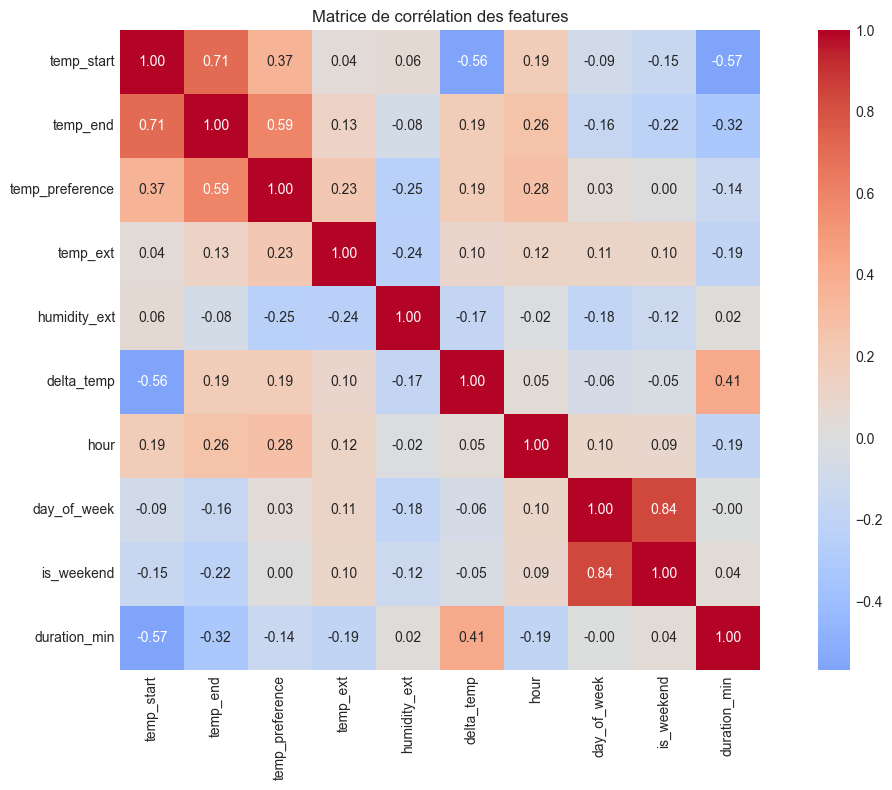


=== Corrélations avec duration_min ===
duration_min       1.000000
delta_temp         0.411609
is_weekend         0.039983
humidity_ext       0.023719
day_of_week       -0.002641
temp_preference   -0.143449
temp_ext          -0.186792
hour              -0.194697
temp_end          -0.322650
temp_start        -0.569176
Name: duration_min, dtype: float64


In [77]:
# Matrice de corrélation
if not sessions_df.empty:
    numeric_cols = sessions_df.select_dtypes(include=[np.number]).columns
    corr_matrix = sessions_df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True)
    plt.title('Matrice de corrélation des features')
    plt.tight_layout()
    plt.show()
    
    # Corrélations avec la variable cible
    print("\n=== Corrélations avec duration_min ===")
    target_corr = corr_matrix['duration_min'].sort_values(ascending=False)
    print(target_corr)

---
## 4. Feature Engineering

Création de features avancées pour améliorer la performance du modèle.

In [85]:
def load_and_clean_data(path: str, quantile_low: float = 0.05, quantile_high: float = 0.95) -> pd.DataFrame:
    df = pd.read_csv(path)
    
    initial_count = len(df)
    
    # Filtrer les outliers (sessions trop longues ou trop courtes)
    q1 = df['duration_min'].quantile(quantile_low)
    q3 = df['duration_min'].quantile(quantile_high)
    df = df[(df['duration_min'] >= q1) & (df['duration_min'] <= q3)]
    
    print(f"   Avant nettoyage: {initial_count}")
    print(f"   Après nettoyage: {len(df)} ({100*len(df)/initial_count:.1f}%)")
    
    return df


def prepare_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    df = df.copy()
    
    # Encodage catégoriel
    le_room = LabelEncoder()
    le_apt = LabelEncoder()
    df["room_encoded"] = le_room.fit_transform(df["room"])
    df["apt_encoded"] = le_apt.fit_transform(df["apartment_id"])
    
    # Features temporelles binaires
    # TODO: mb develop more 
    df["morning"] = ((df["hour"] >= 6) & (df["hour"] < 10)).astype(int)
    df["day"] = ((df["hour"] >= 10) & (df["hour"] < 17)).astype(int)
    df["evening"] = ((df["hour"] >= 17) & (df["hour"] < 22)).astype(int)
    
    # Features dérivées
    df["delta_squared"] = df["delta_temp"] ** 2
    df["temp_diff_ext"] = df["temp_start"] - df["temp_ext"]
    df["heating_difficulty"] = df["delta_temp"] * (20 - df["temp_ext"]) / 10
    df["target_gap"] = df["temp_preference"] - df["temp_start"]
    
    # Features d'interaction
    # TODO: mb develop more 
    df["delta_x_hour"] = df["delta_temp"] * df["hour"]
    df["ext_x_hour"] = df["temp_ext"] * df["hour"]
    
    feature_columns = [
        "delta_temp", "delta_squared", "temp_ext", "temp_start",
        "temp_preference", "humidity_ext", "hour",
        "room_encoded", "apt_encoded",
        "morning", "day", "evening",
        "temp_diff_ext", "heating_difficulty", "target_gap",
        "delta_x_hour", "ext_x_hour"
    ]
    
    available = [c for c in feature_columns if c in df.columns]
    
    X = df[available].astype(float)
    y = df["duration_min"]
    
    return X, y, available


print("📊 Chargement et nettoyage des données...")
df_clean = load_and_clean_data(CONFIG['output_csv'])

print("\n🔧 Feature engineering...")
X, y, features = prepare_features(df_clean)
print(f"   {len(features)} features créées")
# print(X)
# print(y)
print(f"   Features: {features}")


📊 Chargement et nettoyage des données...
   Avant nettoyage: 3608
   Après nettoyage: 3526 (97.7%)

🔧 Feature engineering...
   17 features créées
   Features: ['delta_temp', 'delta_squared', 'temp_ext', 'temp_start', 'temp_preference', 'humidity_ext', 'hour', 'room_encoded', 'apt_encoded', 'morning', 'day', 'evening', 'temp_diff_ext', 'heating_difficulty', 'target_gap', 'delta_x_hour', 'ext_x_hour']


In [86]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state']
)

print(f"📈 Split des données:")
print(f"   Train: {len(X_train)} échantillons")
print(f"   Test:  {len(X_test)} échantillons")

📈 Split des données:
   Train: 2820 échantillons
   Test:  706 échantillons


---
## 5. Entraînement du Modèle

Entraînement avec XGBoost et optimisation des hyperparamètres via GridSearchCV.

In [114]:
# === Comparaison de Modèles ===
print("🚀 Comparaison de plusieurs algorithmes...")

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=CONFIG['random_state']),
    "XGBoost": xgb.XGBRegressor(n_estimators=400, max_depth=6, 
                                learning_rate=0.02, min_child_weight=3, 
                                subsample=0.7, colsample_bytree=0.8,
                                reg_alpha=0.2, reg_lambda=1.0, 
                                random_state=CONFIG['random_state'])
}

results = []

for name, model in models.items():
    print(f"   Entraînement {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        "Model": name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\n📊 Résultats de la comparaison :")
display(results_df)

# On garde XGBoost comme référence pour la suite (compatible GridSearch spécifique)
baseline_model = models["XGBoost"]


🚀 Comparaison de plusieurs algorithmes...
   Entraînement Linear Regression...
   Entraînement Random Forest...
   Entraînement XGBoost...

📊 Résultats de la comparaison :


,Model,R2,MAE,RMSE
2,XGBoost,0.699940,10.076876,13.879681
1,Random Forest,0.672415,10.466759,14.502326
0,Linear Regression,0.491774,13.668035,18.063604


In [115]:
# GridSearchCV pour optimisation
print("🔍 GridSearchCV pour optimisation des hyperparamètres...")

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.02, 0.03],
    'min_child_weight': [1, 3, 5],
}

base_model = xgb.XGBRegressor(
    subsample=0.7, 
    colsample_bytree=0.8,
    reg_alpha=0.2, 
    reg_lambda=1.0, 
    random_state=CONFIG['random_state']
)

grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n✅ Meilleurs hyperparamètres trouvés:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n   Meilleur R² (CV): {grid_search.best_score_:.3f}")

🔍 GridSearchCV pour optimisation des hyperparamètres...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Meilleurs hyperparamètres trouvés:
   learning_rate: 0.02
   max_depth: 6
   min_child_weight: 1
   n_estimators: 300

   Meilleur R² (CV): 0.698


In [124]:
# Modèle optimisé avec régularisation
print("🎯 Entraînement du modèle final optimisé...")

best_params = grid_search.best_params_

final_model = xgb.XGBRegressor(
    **best_params,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=1.0,
    random_state=CONFIG['random_state']
)

final_model.fit(X_train, y_train)

# Évaluation finale
y_pred_final = final_model.predict(X_test)
r2_final = r2_score(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"\n📊 Résultats Modèle Final:")
print(f"   R² Score: {r2_final:.3f} ({r2_final*100:.1f}%)")
print(f"   MAE:      {mae_final:.2f} min")
print(f"   RMSE:     {rmse_final:.2f} min")


# Cross-validation sur le modèle final
print("📈 Cross-validation (5-fold)...")
cv_scores = cross_val_score(final_model, X, y, cv=10, scoring='r2')

print(f"   Scores par fold: {[f'{s:.3f}' for s in cv_scores]}")
print(f"   Moyenne:  {cv_scores.mean():.3f}")
print(f"   Écart-type: {cv_scores.std():.3f}")

🎯 Entraînement du modèle final optimisé...

📊 Résultats Modèle Final:
   R² Score: 0.699 (69.9%)
   MAE:      10.07 min
   RMSE:     13.90 min
📈 Cross-validation (5-fold)...
   Scores par fold: ['0.310', '0.467', '0.552', '0.589', '0.558', '0.408', '0.933', '0.727', '0.875', '0.490']
   Moyenne:  0.591
   Écart-type: 0.189


---
## 6. Évaluation et Analyse du Modèle

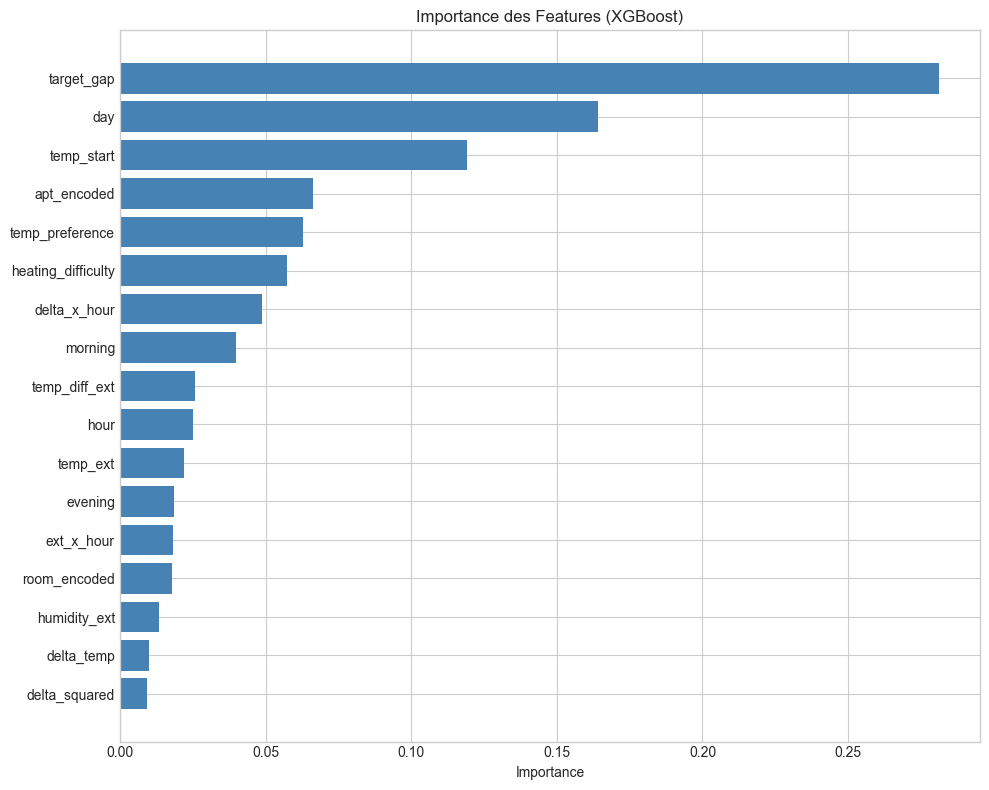


=== Top 5 Features ===
        feature  importance
temp_preference    0.062954
    apt_encoded    0.066379
     temp_start    0.119204
            day    0.164129
     target_gap    0.281211


In [127]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Importance des Features (XGBoost)')
plt.tight_layout()
plt.show()

print("\n=== Top 5 Features ===")
print(feature_importance.tail(5).to_string(index=False))

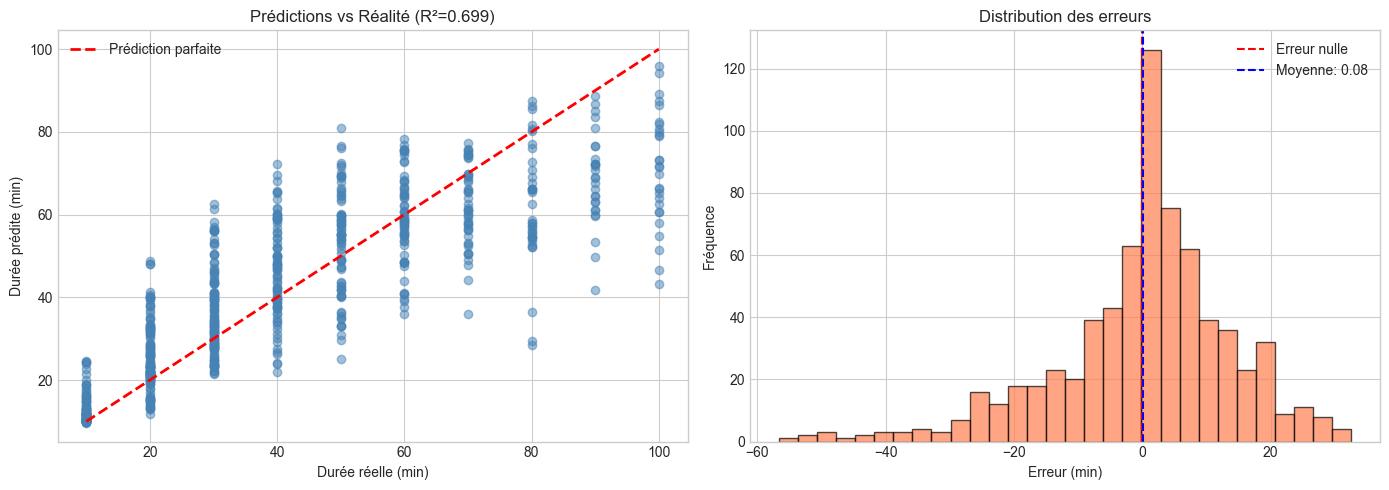


=== Statistiques des erreurs ===
   Erreur moyenne: 0.08 min
   Erreur std:     13.91 min
   Erreur max:     56.68 min


In [126]:
# Visualisation des prédictions vs réalité
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_final, alpha=0.5, c='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prédiction parfaite')
axes[0].set_xlabel('Durée réelle (min)')
axes[0].set_ylabel('Durée prédite (min)')
axes[0].set_title(f'Prédictions vs Réalité (R²={r2_final:.3f})')
axes[0].legend()

# Distribution des erreurs
errors = y_pred_final - y_test
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(0, color='red', linestyle='--', label='Erreur nulle')
axes[1].axvline(errors.mean(), color='blue', linestyle='--', label=f'Moyenne: {errors.mean():.2f}')
axes[1].set_xlabel('Erreur (min)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des erreurs')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n=== Statistiques des erreurs ===")
print(f"   Erreur moyenne: {errors.mean():.2f} min")
print(f"   Erreur std:     {errors.std():.2f} min")
print(f"   Erreur max:     {abs(errors).max():.2f} min")

---
## 7. Export du Modèle

In [ ]:
# Choisir le meilleur modèle et sauvegarder

# Récupérer le meilleur score de la phase de comparaison
# results_df est trié par R2 descendant
best_comparison_r2 = results_df.iloc[0]["R2"]
best_comparison_name = results_df.iloc[0]["Model"]

print(f"Meilleur modèle comparaison: {best_comparison_name} (R2={best_comparison_r2:.3f})")
print(f"Modèle optimisé final: XGBoost Optimisé (R2={r2_final:.3f})")

if r2_final >= best_comparison_r2:
    best_model = final_model
    best_r2 = r2_final
    model_name = "XGBoost Optimisé"
else:
    # On récupère le meilleur modèle de la liste 'models'
    best_model = models[best_comparison_name]
    best_r2 = best_comparison_r2
    model_name = best_comparison_name


if "XGBoost" in model_name:
    best_model.save_model(CONFIG['model_output'])
    print(f"\n💾 Modèle XGBoost sauvegardé: {CONFIG['model_output']}")
else:
    import joblib
    pkl_filename = CONFIG['model_output'].replace('.json', '.pkl')
    joblib.dump(best_model, pkl_filename)
    print(f"\n💾 Modèle sklearn sauvegardé: {pkl_filename}")
    print(f"⚠️ Attention: Le format JSON est attendu par le simulateur, mais le meilleur modèle est {model_name}.")


print("=" * 60)
print(f"🏆 MODÈLE FINAL CHOISI: {model_name}")
print(f"   R² Score: {best_r2:.3f} ({best_r2*100:.1f}%)")
print("=" * 60)

if best_r2 >= CONFIG['target_r2']:
    print(f"\n✅ OBJECTIF ATTEINT! R² ≥ {CONFIG['target_r2']*100:.0f}%")
else:
    print(f"\n R² = {best_r2:.1%} - Objectif {CONFIG['target_r2']*100:.0f}% non atteint")


Meilleur modèle comparaison: XGBoost (R2=0.700)
Modèle optimisé final: XGBoost Optimisé (R2=0.699)

💾 Modèle XGBoost sauvegardé: heating_model.json
🏆 MODÈLE FINAL CHOISI: XGBoost
   R² Score: 0.700 (70.0%)

 R² = 70.0% - Objectif 80% non atteint


In [130]:
# Test de chargement du modèle
print("🔄 Test de chargement du modèle...")

loaded_model = xgb.XGBRegressor()
loaded_model.load_model(CONFIG['model_output'])

# Vérification
y_pred_loaded = loaded_model.predict(X_test)
r2_loaded = r2_score(y_test, y_pred_loaded)

print(f"   R² après rechargement: {r2_loaded:.3f}")
print(f"   ✅ Modèle validé!" if np.isclose(r2_loaded, best_r2) else "   ❌ Erreur de chargement!")

🔄 Test de chargement du modèle...
   R² après rechargement: 0.700
   ✅ Modèle validé!


---
## 8. Exemple d'utilisation du modèle

Comment utiliser le modèle pour faire une prédiction.

In [131]:
def predict_heating_duration(model, delta_temp: float, temp_ext: float, temp_start: float,
                             temp_preference: float = 21, humidity_ext: float = 50,
                             hour: int = 7, room_encoded: int = 0, apt_encoded: int = 0) -> float:
    """
    Prédit la durée de chauffage nécessaire.
    
    Args:
        delta_temp: Écart de température à combler (°C)
        temp_ext: Température extérieure (°C)
        temp_start: Température de départ (°C)
        temp_preference: Température cible (°C)
        humidity_ext: Humidité extérieure (%)
        hour: Heure de la journée (0-23)
        room_encoded: ID encodé de la pièce
        apt_encoded: ID encodé de l'appartement
    
    Returns:
        Durée estimée de chauffage (minutes)
    """
    # Construire les features
    morning = 1 if 6 <= hour < 10 else 0
    day = 1 if 10 <= hour < 17 else 0
    evening = 1 if 17 <= hour < 22 else 0
    
    features = np.array([[
        delta_temp,
        delta_temp ** 2,  # delta_squared
        temp_ext,
        temp_start,
        temp_preference,
        humidity_ext,
        hour,
        room_encoded,
        apt_encoded,
        morning,
        day,
        evening,
        temp_start - temp_ext,  # temp_diff_ext
        delta_temp * (20 - temp_ext) / 10,  # heating_difficulty
        temp_preference - temp_start,  # target_gap
        delta_temp * hour,  # delta_x_hour
        temp_ext * hour,  # ext_x_hour
    ]])
    
    return model.predict(features)[0]


# Exemples de prédiction
print("=== Exemples de prédiction ===")

scenarios = [
    {"delta_temp": 2.0, "temp_ext": 5, "temp_start": 18, "hour": 7, "desc": "Matin froid, +2°C"},
    {"delta_temp": 3.0, "temp_ext": 0, "temp_start": 17, "hour": 6, "desc": "Matin très froid, +3°C"},
    {"delta_temp": 1.5, "temp_ext": 10, "temp_start": 19, "hour": 18, "desc": "Soir doux, +1.5°C"},
    {"delta_temp": 4.0, "temp_ext": -5, "temp_start": 16, "hour": 7, "desc": "Matin glacial, +4°C"},
]

for s in scenarios:
    duration = predict_heating_duration(
        loaded_model,
        delta_temp=s["delta_temp"],
        temp_ext=s["temp_ext"],
        temp_start=s["temp_start"],
        hour=s["hour"]
    )
    print(f"\n{s['desc']}:")
    print(f"   Durée estimée: {duration:.1f} minutes")

=== Exemples de prédiction ===

Matin froid, +2°C:
   Durée estimée: 87.3 minutes

Matin très froid, +3°C:
   Durée estimée: 87.8 minutes

Soir doux, +1.5°C:
   Durée estimée: 93.9 minutes

Matin glacial, +4°C:
   Durée estimée: 90.0 minutes


---
## 📝 Résumé et Conclusions

### Pipeline complet
1. **Extraction** : Chargement des CSV et extraction des sessions de chauffage
2. **Exploration** : Visualisation des distributions et corrélations
3. **Feature Engineering** : Création de 17 features (temporelles, dérivées, interactions)
4. **Entraînement** : XGBoost avec GridSearchCV pour optimisation
5. **Évaluation** : R², MAE, RMSE, cross-validation
6. **Export** : Sauvegarde du modèle au format JSON

### Prochaines étapes
- Générer plus de données avec des scénarios variés
- Tester d'autres algorithmes (LightGBM, CatBoost)
- Intégrer le modèle dans le service de préchauffage